In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

from jax import random

from jax.config import config

from jax_tqdm import loop_tqdm


import functools

config.update("jax_debug_nans", True)

from functools import cache


C:\Users\jakob\AppData\Local\Temp\ipykernel_10836\4141274208.py:7: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


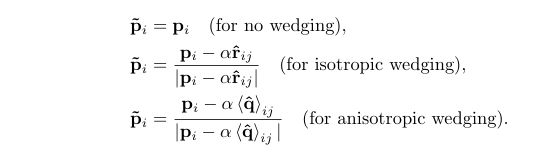

In [84]:
@jit
def unpack_cellrow(cellrow : jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    pos = cellrow[0]
    p = cellrow[1]
    q = cellrow[2]
    return pos, p, q

@jit
def quadruple(a1, a2, b1, b2) -> float: 
    return jnp.dot(jnp.cross(a1, b1), jnp.cross(a2, b2))

@jit
def quadruple_to_angle(a1, a2, b1, b2) -> float:
    return jnp.abs(jnp.arccos(quadruple(a1, a2, b1, b2)) - G["target_angle"])

@jit
def V(r : float, S : float) -> float:
    return jnp.exp(-r) - S * jnp.exp(- r / G["beta"])

@jit
def S_standard(r, p1, q1, p2, q2) -> float:
    S1 = quadruple(p1, p2, r, r)
    S2 = quadruple(p1, p2, q1, q2)
    S3 = quadruple(q1, q2, r, r)
    return G["lambda0"]*S1 + G["lambda1"]*S2 + G["lambda2"]*S3

@jit
def S_angle(r, p1, q1, p2, q2) -> float:
    S1 = quadruple_to_angle(p1, p2, r, r)
    S2 = quadruple_to_angle(p1, p2, q1, q2)
    S3 = quadruple_to_angle(q1, q2, r, r)
    return G["lambda0"]*S1 + G["lambda1"]*S2 + G["lambda2"]*S3

@jit
def S_only_AB(r, p1, q1, p2, q2) -> float:
    S1 = quadruple(p1, p2, r, r)
    return S1

def from_angles_to_vector(phi, theta) -> jnp.ndarray:
    x = jnp.cos(phi)*jnp.sin(theta)
    y = jnp.sin(phi)*jnp.cos(theta)
    z = jnp.sin(phi)
    return jnp.array([x, y, z])

@jit
def U(cellrow1 : jnp.ndarray, cellrow2 : jnp.ndarray, cell2_property : float) -> float:
    pos1, p1, q1 = unpack_cellrow(cellrow1)
    pos2, p2, q2 = unpack_cellrow(cellrow2)

    dir = pos2 - pos1

    # s = S(dir, p1, q1, p2, q2)
    s = jax.lax.cond(cell2_property == 0.0, G["cell_properties"]["standard"]["S"], G["cell_properties"]["non_polar"]["S"], dir, p1, q1, p2, q2)
    
    _dir = jnp.where(jnp.allclose(dir, jnp.zeros(3)), jnp.array([1, 0, 0]), dir)

    r = jnp.linalg.norm(_dir)

    v = V(r, s)

    # add the global potential pointing towards the origin
    corrected_pos_vec = pos2 / G["egg_shape"]
    mag = jnp.dot(corrected_pos_vec, corrected_pos_vec) # squared length

    v_added = jnp.where(mag > 1.0, v + jnp.exp(mag), v)

    # correct for the case where the particles are on top of each other
    v_corrected = jnp.where(jnp.allclose(dir, jnp.zeros(3)), 0.0, v_added)

    return v_corrected

def get_random_points_on_sphere(shape : int, key_int : int) -> jnp.ndarray:
    key = random.PRNGKey(key_int)
    theta = 2 * jnp.pi * random.uniform(key, (shape,))

    key = random.PRNGKey(key_int+2)
    phi = jnp.arccos(1 - 2 * random.uniform(key, (shape,)))

    x = jnp.sin(phi) * jnp.cos(theta)
    y = jnp.sin(phi) * jnp.sin(theta)
    z = jnp.cos(phi)
    return jnp.array([x, y, z]).T


def get_IC(N : int) -> jnp.ndarray:
    pos = get_random_points_on_sphere(N, 42)

    p = pos #/ jnp.linalg.norm(pos, axis=1, keepdims=True)

    pos = pos * G["egg_shape"]

    q = get_random_points_on_sphere(N, 43)

    cells = jnp.stack([pos, p, q], axis=1)

    cell_properties = jnp.where(pos[:,2] < 0, 0, 1)
    # cell_properties = jnp.ones(N)

    print("Number of cells in the upper half:", jnp.sum(cell_properties))

    return cells, cell_properties


@cache
def find_array_that_has_own_indexes(size):
    indx = jnp.repeat(jnp.arange(size[0]), repeats = size[1]).reshape((size[0], size[1]))
    return indx

@functools.partial(jit, static_argnames=["k", "recall_target"])
def l2_ann(qy, db,  k=10, recall_target=0.95):
    half_db_norms = jnp.linalg.norm(db, axis=1)**2 / 2
    dists = half_db_norms - jax.lax.dot(qy, db.transpose())
    return jax.lax.approx_min_k(dists, k=k, recall_target=recall_target)

@functools.partial(jit, static_argnames=["k"])
def find_neighbors(cells : jnp.ndarray, k : int = 10):
    positions = cells[:,0,:]
    dists, neighbors = l2_ann(positions, positions, k=k+1)

    neighbors = neighbors[:,1:] # remove the first neighbor, which is the particle itself

    neighbor_positions = positions[neighbors]  # (N,k,3)

    dx = neighbor_positions - positions[:,None,:]

    d = jnp.linalg.norm(dx, axis=2)

    # # only find those that can interact through voronoi
    n_dis = jnp.sum((dx[:, :, None, :] / 2 - dx[:, None, :, :]) ** 2, axis=3)    # Finding distances from particle k to the midpoint between particles i and j squared for all potential neighbors
    n_dis += 1000 * jnp.eye(n_dis.shape[1])[None, :, :]                  # We add 1000 to the sites that correspond to subtracting the vector ij/2 with ij, so these don't fuck anything up.

    z_mask = jnp.sum(n_dis < (d[:, :, None] ** 2 / 4), axis=2) <= 0

    indx = find_array_that_has_own_indexes((neighbors.shape[0], k))
    actual_neighbors = jnp.where(z_mask, neighbors, indx)

    return actual_neighbors




# compute the energy of the system
@functools.partial(jit, static_argnames=['cell_properties'])
def U_sum(cells : jnp.ndarray, neighbors : jnp.ndarray, cell_properties : jnp.ndarray):

    # empty array to hold the energies
    arr = jnp.empty((cells.shape[0], neighbors.shape[1]), float)

    def loop_fn(i, arr):
        val = jax.vmap(lambda nb: U(cells[i], nb, cell_properties[i]))(cells[neighbors[i,:]])
        arr = arr.at[i,:].set(val)
        return arr
    
    
    arr = jax.lax.fori_loop(0, cells.shape[0], loop_fn, arr)

    final_sum = jnp.sum(arr)

    return final_sum

U_grad = grad(U_sum, argnums=(0))


def take_step(step_indx : int, cells : jnp.ndarray, old_nbs : jnp.ndarray, cell_properties : jnp.ndarray):
    neighbors = jax.lax.cond((step_indx < 30) | (step_indx % 100 == 0), find_neighbors, lambda *args: old_nbs, cells)

    grad_U = U_grad(cells, neighbors, cell_properties)

    # update the positions
    cells = cells - grad_U*G["dt"] 

    # add random noise to the positions
    cells = cells.at[:,0,:].add(random.normal(random.PRNGKey(0), cells.shape[0:2])*G["eta"])

    # normalize p and q
    ns = cells[:,1:,:] / jnp.linalg.norm(cells[:,1:,:], axis=2)[:,:,None]
    cells = cells.at[:,1:,:].set(ns)
    
    return cells, neighbors

take_step = jit(take_step, static_argnames=["cell_properties"])

def main(N_cells : int, N_steps : int, save_every : int = 100, save = 0):
    assert save == 0 or save == 1 or save == 2, "save must be 0, 1 or 2"
    cells, cell_properties = get_IC(N_cells)
    # plot_cells(cells)
    all_cells = jnp.ones((int(N_steps/save_every), N_cells, 3, 3), float)
    old_nbs = jnp.ones((cells.shape[0], 10), int)*-1

    def save_cells(i, cells, all_cells, save_every):
        all_cells = all_cells.at[jnp.floor(i/save_every).astype(int),:,:,:].set(cells)
        return all_cells
    
    if save != 2:
        def save_cells(i, cells, all_cells, save_every):
            return all_cells
    
    def loop_fn(i, cp, save_every=save_every):
        cells, all_cells, old_nbs, cell_properties = cp
        all_cells = jax.lax.cond(i % save_every == 0, lambda : save_cells(i, cells, all_cells, save_every), lambda *args: all_cells)
        cells, old_nbs = take_step(i, cells, old_nbs, cell_properties)
        return cells, all_cells, old_nbs, cell_properties
    
    cells, all_cells, old_nbs, cell_properties = jax.lax.fori_loop(0, N_steps, loop_fn, (cells, all_cells, old_nbs, cell_properties))

    if save == 1:
        np.save("runs/cells_egg_half.npy", cells)
    elif save == 2:
        np.save("runs/cells_egg_half.npy", all_cells)
        np.save("runs/cells_egg_half_properties.npy", cell_properties)
    return cells


G = {
    "beta": 5.0,
    "dt": 0.1,
    "eta": 1e-4, # width of the gaussian noise
    "lambda0": 0.5,
    "lambda1": 0.4,
    "lambda2": 0.1,
    "target_angle": jnp.pi/40,
    "egg_shape": jnp.array([200, 200/3, 200/3]),
    "cell_properties": {
        "standard" : {
            "S" : S_angle
        },
        "non_polar" : {
           "S" : S_only_AB
        },
    }
}


cells = main(2000, 2000, save=2, save_every=10)


# with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
#     cells = main(1000, 1000)
#     cells.block_until_ready()

Number of cells in the upper half: 1003


FloatingPointError: invalid value (nan) encountered in jit(scan)

In [6]:
import matplotlib.pyplot as plt

# 3d plot of the cells
def plot_cells(cells : jnp.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for cell in cells:
        x, p, q = unpack_cellrow(cell)
        ax.scatter(x[0], x[1], x[2],c='r', marker='o', s = 40)
        # ax.scatter(x[0] + p[0], x[1] + p[1], x[2] + p[2],c='b', marker='o', s = 40)
        # ax.quiver(x[0], x[1], x[2], p[0], p[1], p[2], length=1, normalize=True, color='blue')


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    # make the axes have the same scale
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.set_zlim(-50, 50)
    
    plt.show()

